# **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context**
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents.

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance.

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [96]:
# Import and mount google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing the necessary libraries**

In [97]:
# Install tensorflow as it is not pre-installed

!pip install tensorflow

In [98]:
# Essentials
import pandas as pd
import numpy as np
# File format
import h5py
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
# Layers and optimizers
from tensorflow.keras.layers import Flatten, Dense, Activation, LeakyReLU, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Warnings
import warnings
warnings.filterwarnings('ignore')


**Let us check the version of tensorflow.**

In [99]:
# Check version
print(tf.__version__)

2.18.0


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [100]:
# Alocate file Path
path = '/content/drive/MyDrive/CS/SVHN_single_grey1.h5'

In [101]:
# Read and inspect all groups in the file
with h5py.File(path, 'r') as data:
  print("Key (groups):", list(data.keys()))
  for key in data.keys():
    print(f"Shape of '{key}':", data[key].shape)

Key (groups): ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']
Shape of 'X_test': (18000, 32, 32)
Shape of 'X_train': (42000, 32, 32)
Shape of 'X_val': (60000, 32, 32)
Shape of 'y_test': (18000,)
Shape of 'y_train': (42000,)
Shape of 'y_val': (60000,)


**Note**: As we can observe, the data is already split in the test and train data sets, we just need to assign the variables.

  We also have the shape of each set:
    - Shape of 'X_test': (18000, 32, 32)
    - Shape of 'X_train': (42000, 32, 32)
    - Shape of 'X_val': (60000, 32, 32)
    - Shape of 'y_test': (18000,)
    - Shape of 'y_train': (42000,)
    - Shape of 'y_val': (60000,)

In [102]:
# Assign variables and convert to DataFrame
with h5py.File(path, 'r') as data:
    X_train = data['X_train'][:]
    y_train = data['y_train'][:]
    X_test = data['X_test'][:]
    y_test = data['y_test'][:]
    X_val = data['X_val'][:]
    y_val = data['y_val'][:]

Check the number of images in the training and the testing dataset.

In [103]:
# test - 18000 images
# train - 42000 images

In [104]:
# Check distribution of classes
np.unique(y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([4186, 4172, 4197, 4281, 4188, 4232, 4168, 4192, 4188, 4196]))

The classes are evenly distributed

**Observation:**

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

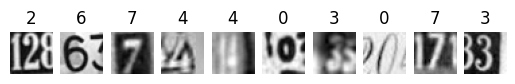

In [105]:
# Subplot format for better visualization
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X_train[i], cmap='gray')
  plt.title(y_train[i])
  plt.axis('off')
plt.show()

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [106]:
# Shape and arrays
print('Shape of dataset: ', X_train.shape)
print('Shape of first image: ', X_train[0].shape, 'pixels')
print('Array of first image: ', X_train[0])

Shape of dataset:  (42000, 32, 32)
Shape of first image:  (32, 32) pixels
Array of first image:  [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


### **Normalize the train and the test data**

In [107]:
# Reshape data set and add channel dimension 1, as it is expected in TF for grayscale
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

# Normalize using explicit type conversation to improve memory efficiency
X_train_n = X_train.astype('float32') / 255.0
X_test_n = X_test.astype('float32') / 255.0

Print the shapes of Training and Test data

In [108]:
print(X_train_n.shape)
print(X_test_n.shape)

(42000, 32, 32, 1)
(18000, 32, 32, 1)


### **One-hot encode output**

In [109]:
# Create 10 categories for the 10 digits available

y_train_e = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_test_e = tf.keras.utils.to_categorical(y_test, num_classes = 10)

# Check if they were created correctly
print(y_train_e[0])
print(y_test_e[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


**Observation:** Categories match from previous printed images. Now we are ready to create the model


## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [110]:
# Set random seed 1
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [111]:
# Function definition
def nn_model_1():
  # Initialize sequential model
  model = Sequential()
  # Flattens the layer, it is a reshape operation. Tranforms the tensor (preserving instrinsic relationship), into a vector by stacking all elelemnrs row-wise.
  model.add(Flatten(input_shape = (32, 32, 1))) # Multiplying the dimensions (32 *32 *1) = 1024, which is the expected input
  # New layer
  # Add 64 neurons, use relu
  model.add(Dense(64, activation = 'relu'))
  # Sprinkle 32 more neurons and seasonate with relu
  model.add(Dense(32, activation = 'relu'))
  # Serve in 10 classes with nodes, and decorate with softmax
  model.add(Dense(10, activation = 'softmax'))
  # Give a final touch of Adam optimizer
  # Set the oven at learning_rate = 0.001
  opt = Adam(learning_rate = 0.001)
  # Bake
  model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
  # Serve and enjoy :)
  return model

In [112]:
# Call function and assign
model_1 = nn_model_1()
print(model_1.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,010 (265.66 KB)

 Trainable params: 68,010 (265.66 KB)

 Non-trainable params: 0 (0.00 B)

None


In [113]:
# Fit the model, save history
history = model_1.fit(X_train_n, y_train_e, validation_split = 0.2, batch_size = 128, verbose = 1, epochs = 20)

Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1046 - loss: 2.3092 - val_accuracy: 0.1038 - val_loss: 2.2966
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1266 - loss: 2.2769 - val_accuracy: 0.1406 - val_loss: 2.2023
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1618 - loss: 2.1845 - val_accuracy: 0.2000 - val_loss: 2.1528
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1874 - loss: 2.1492 - val_accuracy: 0.2058 - val_loss: 2.1362
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1926 - loss: 2.1356 - val_accuracy: 0.2089 - val_loss: 2.1265
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1976 - loss: 2.1271 - val_accuracy: 0.2094 - val_loss: 2.1219
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2003 - loss: 2.1208 - val_accuracy: 0.2031 - val_loss: 2.1294
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2034 - loss: 2.1174 - val_accuracy: 0.

### **Plot the Training and Validation Accuracies and write down your Observations.**

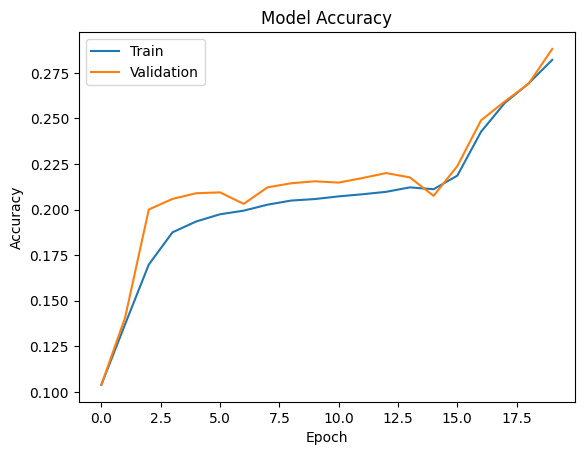

In [114]:
# Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations: The model's performance is very poor, the accuracy is bellow 0.3. Validation and training sets are performing similarly, suggesting that the model is not learning effectively.**

Let's build one more model with higher complexity and see if we can improve the performance of the model.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [115]:
# Clear history and fix seed
tf.keras.backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [116]:
# Function definition
def nn_model_2():
  # Initialize sequential model
  model = Sequential()
  # Flattens the layer, it is a reshape operation. Tranforms the tensor (preserving instrinsic relationship), into a vector by stacking all elelemnrs row-wise.
  model.add(Flatten(input_shape = (32, 32, 1))) # Multiplying the dimensions (32 *32 *1) = 1024, which is the expected input
  # New layer
  # Start with 256 neurons, use relu
  model.add(Dense(256, activation = 'relu'))
  # Generously add another 128 neurons, use relu
  model.add(Dense(128, activation = 'relu'))
  # Drop
  model.add(Dropout(0.2))
  # Third layer, mix with 64 more neurons, while incoprorating relu
  model.add(Dense(64, activation = 'relu'))
  # Fourth Layer, add 64 neurons, don't forget your relu
  model.add(Dense(64, activation = 'relu'))
  # Sprinkle 32 more neurons and seasonate with relu
  model.add(Dense(32, activation = 'relu'))
  # Normalize before serving
  model.add(BatchNormalization())
  # Serve in 10 classes with nodes, and decorate with softmax
  model.add(Dense(10, activation = 'softmax'))
  # Give a final touch of Adam optimizer
  # Set the oven at learning_rate = 0.005
  opt = Adam(learning_rate = 0.005)
  # Bake
  model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
  # Serve and enjoy :)
  return model

In [117]:
# Call function and assign
model_2 = nn_model_2()
print(model_2.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,250 (1.18 MB)

 Trainable params: 310,186 (1.18 MB)

 Non-trainable params: 64 (256.00 B)

None


In [118]:
history2 = model_2.fit(X_train_n, y_train_e, validation_split = 0.2, batch_size = 128, verbose = 1, epochs = 30)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1000 - loss: 2.3713 - val_accuracy: 0.1004 - val_loss: 2.3153
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0992 - loss: 2.3078 - val_accuracy: 0.1020 - val_loss: 2.3142
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1008 - loss: 2.3074 - val_accuracy: 0.1002 - val_loss: 2.3158
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0990 - loss: 2.3083 - val_accuracy: 0.1004 - val_loss: 2.3125
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0981 - loss: 2.3075 - val_accuracy: 0.0970 - val_loss: 2.3078
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0947 - loss: 2.3064 - val_accuracy: 0.1027 - val_loss: 2.3075
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1149 - loss: 2.2893 - val_accuracy: 0.1789 - val_loss: 2.1301
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1872 - loss: 2.1067 - val_accuracy: 0

### **Plot the Training and Validation Accuracies and write down your Observations.**

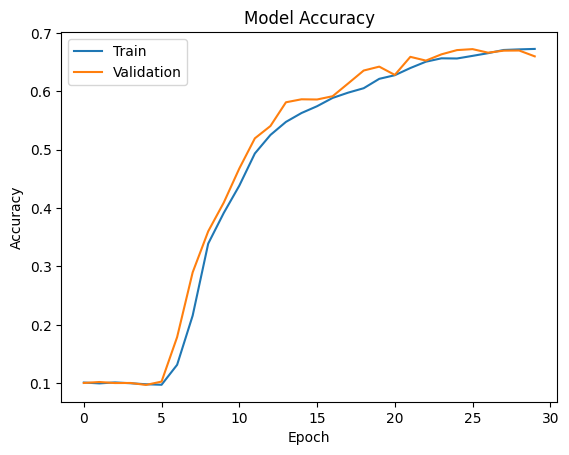

In [119]:
# Plot
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations: The model has improved significantly compared to the first iteration, yet it remains somewhat inaccurate, achieving below 0.7 accuracy. Increasing the number of neurons helped improve performance, but we can conclude that this is not the optimal approach for this image classification problem.**

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [120]:
# Predict and evaluate
predictions = model_2.predict(X_test_n)
accuracy = model_2.evaluate(X_test_n, y_test_e)

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6723 - loss: 1.0209


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [121]:
# Convert probalilities to discrete classes
y_pred_arg = np.argmax(predictions, axis=1)
y_test_arg = np.argmax(y_test_e, axis=1)

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

Classification report: 
 
               precision    recall  f1-score   support

           0       0.79      0.64      0.70      1814
           1       0.62      0.77      0.68      1828
           2       0.69      0.61      0.65      1803
           3       0.69      0.61      0.64      1719
           4       0.72      0.79      0.76      1812
           5       0.56      0.67      0.61      1768
           6       0.74      0.65      0.69      1832
           7       0.57      0.81      0.67      1808
           8       0.76      0.52      0.62      1812
           9       0.70      0.62      0.66      1804

    accuracy                           0.67     18000
   macro avg       0.68      0.67      0.67     18000
weighted avg       0.68      0.67      0.67     18000



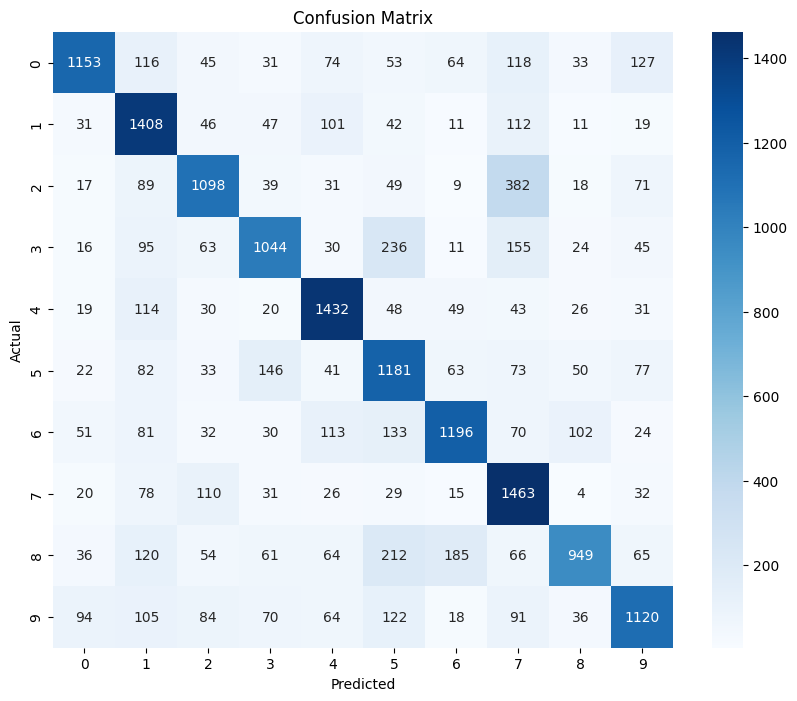

In [122]:
# Classification report
print("Classification report: \n \n", classification_report(y_test_arg, y_pred_arg))

# Confusion Matrix, using heatmap
cm = confusion_matrix(y_test_arg, y_pred_arg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Final Observations: **

The model has an F1-score of 0.67, it can make some predictions correctly, but it is far from perfect. The most frequent error occurred with the number 8, which was misclassified as different numbers several times, most commonly as 5. The model also interpreted the number 2 as a 7 on 382 occasions, representing the biggest misclassification error. However, the numbers with the best predictions overall were 7, 4, and 1.


## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [123]:
# Read and inspect all groups in the file
with h5py.File(path, 'r') as data:
  print("Key (groups):", list(data.keys()))
  for key in data.keys():
    print(f"Shape of '{key}':", data[key].shape)

Key (groups): ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']
Shape of 'X_test': (18000, 32, 32)
Shape of 'X_train': (42000, 32, 32)
Shape of 'X_val': (60000, 32, 32)
Shape of 'y_test': (18000,)
Shape of 'y_train': (42000,)
Shape of 'y_val': (60000,)


In [124]:
# Assign variables and convert to DataFrame
with h5py.File(path, 'r') as data:
    X_train = data['X_train'][:]
    y_train = data['y_train'][:]
    X_test = data['X_test'][:]
    y_test = data['y_test'][:]
    X_val = data['X_val'][:]
    y_val = data['y_val'][:]

Check the number of images in the training and the testing dataset.

In [125]:
# test - 18000 images
# train - 42000 images

**Observation: The data is already split, with 42,000 images for training and 18,000 images for testing**


## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [126]:
# Shape and array
print('Shape of dataset: ', X_train.shape)
print('Shape of first image: ', X_train[0].shape, 'pixels')
print('Array of first image: ', X_train[0])

Shape of dataset:  (42000, 32, 32)
Shape of first image:  (32, 32) pixels
Array of first image:  [[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [127]:
# Reshape data set and add channel dimension 1, as it is expected in TF for grayscale
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

Normalize inputs from 0-255 to 0-1

In [128]:
# Normalize using explicit type conversation to improve memory efficiency
X_train_n = X_train.astype('float32') / 255.0
X_test_n = X_test.astype('float32') / 255.0

Print New shape of Training and Test

In [129]:
print(X_train_n.shape)
print(X_test_n.shape)

(42000, 32, 32, 1)
(18000, 32, 32, 1)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [130]:
# Create 10 categories for the 10 digits available

y_train_e = tf.keras.utils.to_categorical(y_train, num_classes = 10)
y_test_e = tf.keras.utils.to_categorical(y_test, num_classes = 10)

# Check if they were created correctly
print(y_train_e[0])
print(y_test_e[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


**Observation: The data is well prepared for model building**


## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [131]:
# Set random seed
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [132]:
def cnn_model_1():
  # Initialize sequential model
  model = Sequential()
  # First layer, convolutional, 16 filters
  model.add(Conv2D(16, (3, 3), padding = 'same', input_shape = (32, 32, 1)))
  # 1st LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # Second layer, convolutional, 32 filters
  model.add(Conv2D(32, (3, 3), padding = 'same'))
  # 2nd LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # Max pooling
  model.add(MaxPooling2D(pool_size = (2, 2)))
  # Flatten
  model.add(Flatten())
  # Dense layer, 32 nodes
  model.add(Dense(32))
  # 3rd LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # Output layer
  model.add(Dense(10, activation = 'softmax'))
  # Optimizer
  opt = Adam(learning_rate = 0.001)
  # Bake
  model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
  # Serve and enjoy :)
  return model

In [133]:
# Call and assign
model_3 = cnn_model_1()
print(model_3.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │         262,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 267,306 (1.02 MB)

 Trainable params: 267,306 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

None


In [134]:
history3 = model_3.fit(X_train_n, y_train_e, validation_split = 0.2, batch_size = 32, verbose = 1, epochs = 20)

Epoch 1/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4804 - loss: 1.5091 - val_accuracy: 0.8224 - val_loss: 0.6105
Epoch 2/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8352 - loss: 0.5580 - val_accuracy: 0.8413 - val_loss: 0.5383
Epoch 3/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8659 - loss: 0.4531 - val_accuracy: 0.8465 - val_loss: 0.5228
Epoch 4/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8849 - loss: 0.3898 - val_accuracy: 0.8552 - val_loss: 0.5105
Epoch 5/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8999 - loss: 0.3416 - val_accuracy: 0.8605 - val_loss: 0.5064
Epoch 6/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9115 - loss: 0.3009 - val_accuracy: 0.8611 - val_loss: 0.5153
Epoch 7/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9205 - loss: 0.2682 - val_accuracy: 0.8589 - val_loss: 0.5297
Epoch 8/20
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9283 - loss: 0.2419 - 

### **Plot the Training and Validation Accuracies and Write your observations.**

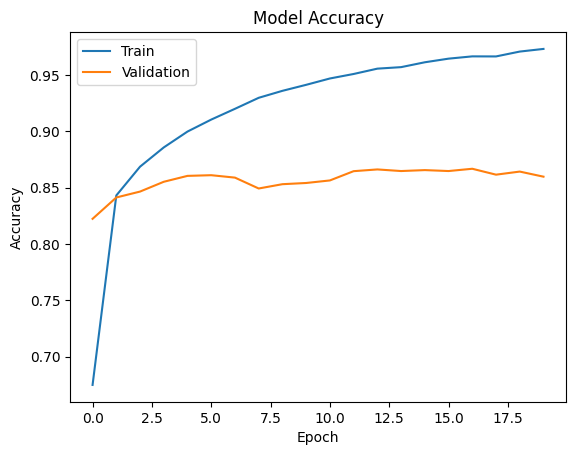

In [135]:
# Plot
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations: **

The accuracy has improved greatly, reaching an accuracy of 0.97. Changing to a CNN seems like the correct approach for the classification problem. However, the validation set is behaving differently, not even reaching 0.9 accuracy. This is a clear sign that the model is overfitting.

Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [136]:
# Clear history and fix seed
tf.keras.backend.clear_session()
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [137]:
def cnn_model_2():
  # Initialize sequential model
  model = Sequential()
  # 1st layer, convolutional, 16 filters
  model.add(Conv2D(16, (3, 3), padding = 'same', input_shape = (32, 32, 1)))
  # 1st LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # 2nd layer, convolutional, 32 filters
  model.add(Conv2D(32, (3, 3), padding = 'same'))
  # 2nd LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # First pooling
  model.add(MaxPooling2D(pool_size = (2, 2)))
  # 1st Normalization
  model.add(BatchNormalization())
  # 3rd layer, convolutional, 32 filters
  model.add(Conv2D(32, (3, 3), padding = 'same'))
  # 3rd LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # 4rd layer, convulational, 64 filters
  model.add(Conv2D(64, (3, 3), padding = 'same'))
  # 4rd LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # Max pooling
  model.add(MaxPooling2D(pool_size = (2, 2)))
  # 2nd Normalization
  model.add(BatchNormalization())
  # Flatten
  model.add(Flatten())
  # Dense layer, 32 nodes
  model.add(Dense(32))
  # 5th LeakyRelu with slope 0.1
  model.add(LeakyReLU(alpha = 0.1))
  # Drop
  model.add(Dropout(0.5))
  # Output layer
  model.add(Dense(10, activation = 'softmax'))
  # Optimizer
  opt = Adam(learning_rate = 0.001)
  # Bake
  model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
  # Serve and enjoy :)
  return model

In [138]:
model_4 = cnn_model_2()
print(model_4.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         131,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,362 (642.04 KB)

 Trainable params: 164,170 (641.29 KB)

 Non-trainable params: 192 (768.00 B)

None


In [139]:
history4 = model_4.fit(X_train_n, y_train_e, validation_split = 0.2, batch_size = 128, verbose = 1, epochs = 30)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3952 - loss: 1.7690 - val_accuracy: 0.2606 - val_loss: 2.6763
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7830 - loss: 0.6990 - val_accuracy: 0.8274 - val_loss: 0.5535
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8262 - loss: 0.5632 - val_accuracy: 0.8777 - val_loss: 0.4136
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8515 - loss: 0.4881 - val_accuracy: 0.8890 - val_loss: 0.3919
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8678 - loss: 0.4303 - val_accuracy: 0.8960 - val_loss: 0.3712
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8794 - loss: 0.3924 - val_accuracy: 0.8973 - val_loss: 0.3800
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8841 - loss: 0.3704 - val_accuracy: 0.8852 - val_loss: 0.4068
Epoch 8/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8949 - loss: 0.3380 - val_accuracy: 0

### **Plot the Training and Validation accuracies and write your observations.**

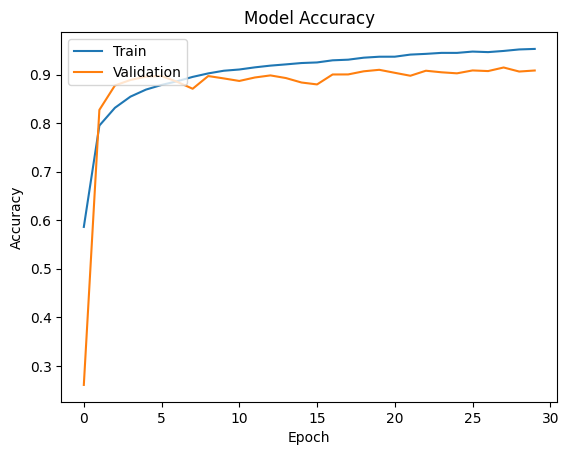

In [141]:
# Plot
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observations:** The model is no longer overfitting, as both datasets are behaving similarly, obtaining an accuracy of 0.95. The additional layers reduced overfitting, and we have reached an optimal model ready to make predictions.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.**

In [142]:
# Predict and evaluate
predictions2 = model_4.predict(X_test_n)
accuracy2 = model_4.evaluate(X_test_n, y_test_e)

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9125 - loss: 0.4352


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [144]:
# Convert probalilities to discrete classes
y_pred_arg2 = np.argmax(predictions2, axis=1)
y_test_arg2 = np.argmax(y_test_e, axis=1)

Classification report: 
 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      1814
           1       0.90      0.90      0.90      1828
           2       0.93      0.91      0.92      1803
           3       0.90      0.87      0.88      1719
           4       0.90      0.94      0.92      1812
           5       0.89      0.91      0.90      1768
           6       0.90      0.89      0.90      1832
           7       0.92      0.92      0.92      1808
           8       0.87      0.92      0.89      1812
           9       0.91      0.90      0.91      1804

    accuracy                           0.91     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.91      0.91      0.91     18000



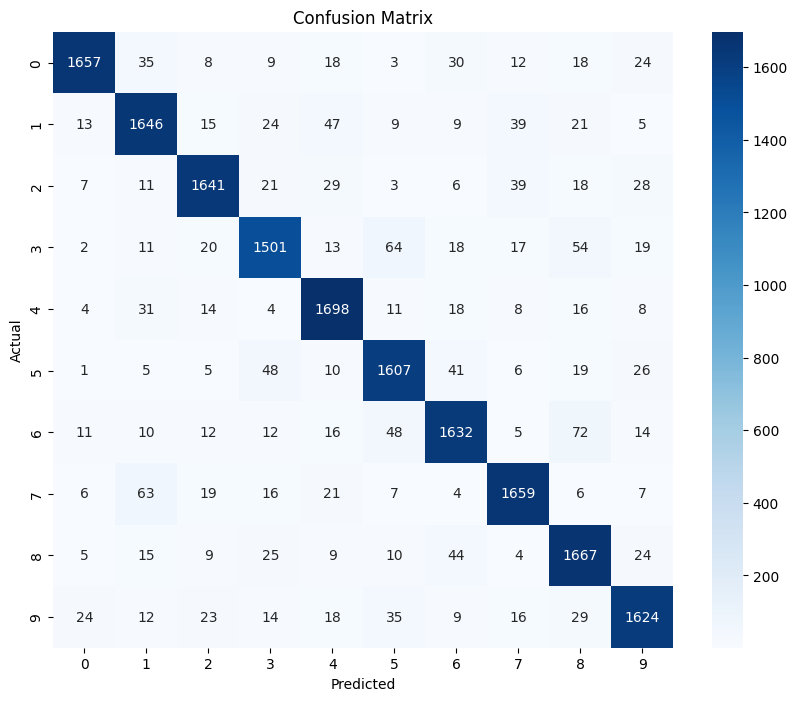

In [145]:
# Classification report
print("Classification report: \n \n", classification_report(y_test_arg2, y_pred_arg2))

# Confusion Matrix, using heatmap
cm = confusion_matrix(y_test_arg2, y_pred_arg2)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Write your final observations on the performance of the model on the test data.**

**Final Observations:** We have obtained a final model that correctly predicts the numbers, achieving an F1-score of 0.91. It makes minimal prediction errors and performs well.